## Load data

In [1]:
import os
import pandas as pd

from PIL import Image
import numpy as np
from sklearn.utils import shuffle, resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [ ]:
!pip install ray
!pip install -U "ray[tune]"  # installs Ray + dependencies for Ray Tune
!pip install -U "ray[rllib]"  # installs Ray + dependencies for Ray RLlib
!pip install -U "ray[serve]"  # installs Ray + dependencies for Ray Serve

In [ ]:
import sys
! pip install nltk
!{sys.executable} -m pip -q install scikit-surprise
!{sys.executable} -m pip -q install category_encoders
!pip install recmetrics

#Load pandas library:
import pandas as pd
# round the data in the correlation matrix
import numpy as np
import math
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
palette = sns.color_palette("RdBu", 10)

#This library is for encoding
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
#Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
#This library is for the model base collaborative filtering recommender
from surprise import SVD, NMF, SVDpp
#this is for puting the data to the model
from surprise import Dataset, Reader
#this is for hyperparameter tuning
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
import recmetrics

#This is libraries for the content based
import joblib
from joblib import parallel_backend # added line.
from ray.util.joblib import register_ray # added line.
register_ray() # added line.
#This is for convert words to vectors
import re
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('popular')
nltk.download("punkt")

# ignore DeprecationWarning Eror Messages
import warnings
warnings.filterwarnings('ignore')

#The pickle is for saving model
import pickle

register_ray()

In [2]:
data_dir = "Flowers/"
classes = os.listdir(data_dir)
num_classes = len(classes)
images = []
labels = []
new_image_size = (225, 225) # set the size of the new images

# Loop through each class folder
for i, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        # Load each image and resize it to the same size
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).convert('L')
        img = img.resize(new_image_size)
        images.append(np.asarray(img).reshape(-1))
        labels.append(i)

# Convert image and label lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Shuffle the data
images, labels = shuffle(images, labels, random_state=42)

## Visualise the data

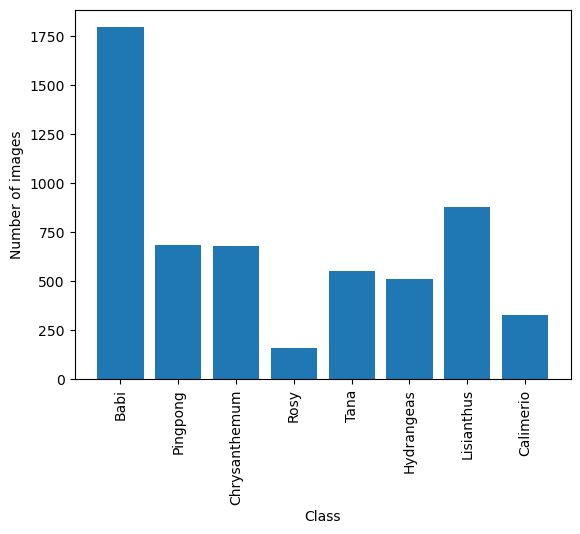

In [3]:
# Count the number of images in each class
class_counts = np.zeros(num_classes)
for label in labels:
    class_counts[label] += 1

# Visualize the class distribution
plt.bar(range(num_classes), class_counts)
plt.xticks(range(num_classes), classes, rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

## Balance the data

In [4]:
# Upsample the minority classes to balance the class distribution
class_counts = np.bincount(labels)
max_class_size = class_counts.max()
for class_idx in range(num_classes):
    if class_counts[class_idx] < max_class_size:
        class_images = images[labels == class_idx]
        class_labels = labels[labels == class_idx]
        num_to_add = max_class_size - class_counts[class_idx]
        new_images, new_labels = resample(class_images, class_labels, n_samples=num_to_add, replace=True, random_state=42)
        images = np.concatenate([images, new_images], axis=0)
        labels = np.concatenate([labels, new_labels], axis=0)

# Shuffle the data again
images, labels = shuffle(images, labels, random_state=42)


## Image pixel distribution

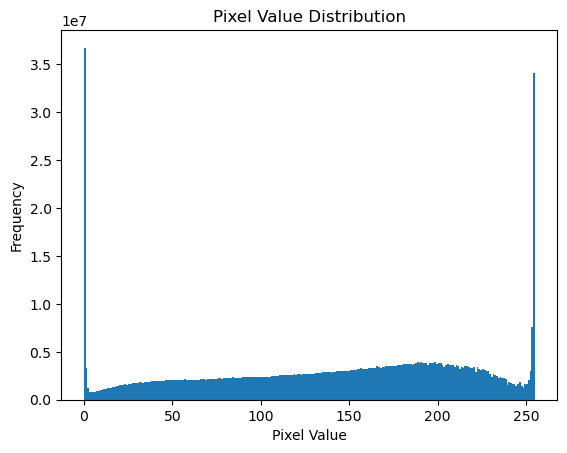

In [5]:
import matplotlib.pyplot as plt

# plot histogram of pixel values
plt.hist(images.ravel(), bins=256, range=(0, 255))
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

## Scaling data

In [6]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
images = scaler.fit_transform(images)

# Reshape the images back to their original dimensions
images = images.reshape(-1, new_image_size[0], new_image_size[1])

## Split data

In [7]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [8]:
X_train

array([[[ 0.93067676,  0.85272658,  0.88667489, ...,  0.97806516,
          1.01579627,  1.01043302],
        [ 0.86635447,  0.79788796,  0.84409349, ...,  0.97924225,
          1.00107888,  0.99902945],
        [ 0.84564191,  0.79019269,  0.83902737, ...,  0.97444323,
          0.97982809,  0.97686162],
        ...,
        [ 0.90935413,  0.82920393,  0.76928496, ...,  0.81459375,
          0.74958938,  0.74718884],
        [ 0.86045618,  0.80502111,  0.77893339, ...,  0.77303666,
          0.73410191,  0.73421218],
        [ 0.82466484,  0.79479796,  0.81696271, ...,  0.76238176,
          0.73912543,  0.73617847]],

       [[ 0.40246648,  0.14339275, -0.1133274 , ...,  0.72020564,
          0.7238917 ,  0.69651547],
        [ 0.76488803,  0.5386344 ,  0.19107651, ...,  0.7207257 ,
          0.72002325,  0.70702296],
        [ 0.48428472,  0.7338135 ,  0.80518115, ...,  0.72680849,
          0.72123038,  0.70729505],
        ...,
        [ 1.20965935,  1.25676506,  1.3010598 , ...,  

## Recommend the flowers

In [15]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from sklearn.model_selection import train_test_split

# Assuming you have a list of image paths in the 'images' variable
# and a corresponding list of labels in the 'labels' variable

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Assuming you have an input flower image path in the 'input_image' variable
# and you want to recommend 10 similar images
def load_image_and_extract_features(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute HOG features
    hog = cv2.HOGDescriptor()
    features = hog.compute(gray_image)

    # Flatten the feature vector and convert to a list
    features = features.flatten().tolist()

    return features


def recommend_similar_images(input_image, num_recommendations=10):
    # Load the input image and convert it into a feature vector
    input_feature_vector = load_image_and_extract_features(input_image)

    # Load and extract features for all images in the validation set
    val_feature_vectors = []
    for image_path in X_val:
        feature_vector = load_image_and_extract_features(image_path)
        val_feature_vectors.append(feature_vector)

    # Convert the feature vectors to numpy arrays
    input_feature_vector = np.array(input_feature_vector)
    val_feature_vectors = np.array(val_feature_vectors)

    # Compute cosine similarity between the input image and all validation images
    similarities = cosine_similarity(input_feature_vector.reshape(1, -1), val_feature_vectors)

    # Get indices of the top similar images
    top_indices = similarities.argsort()[0][-num_recommendations:]

    # Get the paths of the top similar images
    top_images = [X_val[i] for i in top_indices]

    return top_images

# Example usage
input_image = 'MyImage/Babi/Babi.jpeg'
recommended_images = recommend_similar_images(input_image, num_recommendations=10)
print(recommended_images)


TypeError: Can't convert object to 'str' for 'filename'

In [ ]:
stop

## Classification report

### ***Test set***

In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_val, y_pred_classes, target_names=classes))

### ***Train set***

In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_train, y_pred_classes, target_names=classes))


## Visualise the result

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [3]:
import os
import numpy as np
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

def extract_features(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))  # Resize the image to a common size for feature extraction
    return np.array(img).ravel()

def content_based_recommendation(query_image_path, train_data_path):
    # Extract features from the query image
    query_features = extract_features(query_image_path)
    
    # Initialize a dictionary to store cosine similarity scores
    similarity_scores = {}
    
    # Iterate over the subfolders in the train data directory
    for folder_name in os.listdir(train_data_path):
        folder_path = os.path.join(train_data_path, folder_name)
        if not os.path.isdir(folder_path):
            continue
        
        # Iterate over the image files in each subfolder
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            
            # Extract features from the train image
            train_features = extract_features(image_path)
            
            # Calculate the cosine similarity between query and train features
            similarity = cosine_similarity([query_features], [train_features])[0][0]
            
            # Store the similarity score for the current train image
            similarity_scores[image_path] = similarity
    
    # Sort the similarity scores in descending order
    sorted_scores = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Display the top 10 recommended images
    for i in range(10):
        image_path, similarity = sorted_scores[i]
        print(f"Recommended Image {i+1}: {image_path} (Similarity Score: {similarity})")

# Example usage
query_image_path = "MyImage/Babi/Babi.jpeg"
train_data_path = "Flowers/"

content_based_recommendation(query_image_path, train_data_path)


Recommended Image 1: Flowers/Babi/babi_751.jpg (Similarity Score: 0.928652794130944)
Recommended Image 2: Flowers/Lisianthus/lisianthus_114.jpg (Similarity Score: 0.9277051166085342)
Recommended Image 3: Flowers/Babi/babi_617.jpg (Similarity Score: 0.9273501098399035)
Recommended Image 4: Flowers/Babi/babi_846.jpg (Similarity Score: 0.9269309863617841)
Recommended Image 5: Flowers/Babi/babi_569.jpg (Similarity Score: 0.9266741864495196)
Recommended Image 6: Flowers/Babi/babi_543.jpg (Similarity Score: 0.926228834829629)
Recommended Image 7: Flowers/Hydrangeas/hydrangeas_51.jpg (Similarity Score: 0.9257206491151836)
Recommended Image 8: Flowers/Pingpong/pingpong_96.jpg (Similarity Score: 0.9255890011134337)
Recommended Image 9: Flowers/Hydrangeas/hydrangeas_133.jpg (Similarity Score: 0.9254576591209835)
Recommended Image 10: Flowers/Hydrangeas/hydrangeas_46.jpg (Similarity Score: 0.925435194665233)
